In [1]:
import os, sys
import numpy as np
import torch
import json

sys.path.append("..")
from singleVis.SingleVisualizationModel import VisModel
from singleVis.data import NormalDataProvider
from singleVis.eval.evaluator import Evaluator
from singleVis.projector import Projector, tfDVIProjector, TimeVisProjector

In [2]:
# tensorflow
visible_device = "0,1,2,3"
os.environ["CUDA_VISIBLE_DEVICES"] = visible_device

In [3]:
dataset = "cifar10"
noise_type = "symmetric"
noise_rate = "5"

In [4]:
path = "/home/xianglin/projects/DVI_data/noisy/{}/{}/{}/clean_label.json".format(noise_type, dataset, noise_rate)
with open(path, "r") as f:
    clean_label = json.load(f)
path = "/home/xianglin/projects/DVI_data/noisy/{}/{}/{}/noisy_label.json".format(noise_type, dataset, noise_rate)
with open(path, "r") as f:
    noisy_label = json.load(f)

clean_label = np.array(clean_label)
noisy_label = np.array(noisy_label)

In [4]:
VIS_METHOD = "TimeVis"

In [5]:
CONTENT_PATH = "/home/xianglin/projects/DVI_data/noisy/{}/{}/{}/".format(noise_type, dataset, noise_rate)
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

In [6]:
CLASSES = config["CLASSES"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]


# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]
# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]

TOTOAL_EPOCH = (EPOCH_END-EPOCH_START)//EPOCH_PERIOD + 1

# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
# net = resnet18()
net = eval("subject_model.{}()".format(NET))

data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, classes=CLASSES, epoch_name="Epoch", verbose=1)

if VIS_METHOD == "tfDVI":
    # Define Projector
    flag = "_temporal_id_withoutB"
    projector = tfDVIProjector(CONTENT_PATH, flag=flag)
elif VIS_METHOD == "TimeVis":
    model = VisModel(ENCODER_DIMS, DECODER_DIMS)
    projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)
elif VIS_METHOD == "DeepDebugger":
    model = VisModel(ENCODER_DIMS, DECODER_DIMS)
    SEGMENTS = VISUALIZATION_PARAMETER["SEGMENTS"]
    projector = Projector(vis_model=model, content_path=CONTENT_PATH, segments=SEGMENTS, device=DEVICE)

Finish initialization...


In [7]:
samples = np.zeros((TOTOAL_EPOCH, 100, 512))
for i in range(EPOCH_START, EPOCH_END, EPOCH_PERIOD):
    e = (i-EPOCH_START)//EPOCH_PERIOD
    samples[e] = data_provider.test_representation(i)[:100]

embeddings_2d = np.zeros((TOTOAL_EPOCH, 100, 2))
for e in range(1, TOTOAL_EPOCH+1, 1):
    embeddings_2d[e-1] = projector.batch_project(e, samples[e-1])
embeddings_2d = np.transpose(embeddings_2d, [1,0,2])


Successfully load the TimeVis visualization model for iteration 1
Successfully load the TimeVis visualization model for iteration 2
Successfully load the TimeVis visualization model for iteration 3
Successfully load the TimeVis visualization model for iteration 4
Successfully load the TimeVis visualization model for iteration 5
Successfully load the TimeVis visualization model for iteration 6
Successfully load the TimeVis visualization model for iteration 7
Successfully load the TimeVis visualization model for iteration 8
Successfully load the TimeVis visualization model for iteration 9
Successfully load the TimeVis visualization model for iteration 10
Successfully load the TimeVis visualization model for iteration 11
Successfully load the TimeVis visualization model for iteration 12
Successfully load the TimeVis visualization model for iteration 13
Successfully load the TimeVis visualization model for iteration 14
Successfully load the TimeVis visualization model for iteration 15
Succ

In [8]:
# samples = np.zeros((TOTOAL_EPOCH, LEN, 512))
# for i in range(EPOCH_START, EPOCH_END, EPOCH_PERIOD):
#     e = (i-EPOCH_START)//EPOCH_PERIOD
#     samples[e] = data_provider.train_representation(i)

In [9]:
# # embeddings_2d = np.zeros((TOTOAL_EPOCH, LEN, 2))
# # for e in range(1, TOTOAL_EPOCH+1, 1):
# #     embeddings_2d[e-1] = projector.batch_project(e, samples[e-1])
# # embeddings_2d = np.transpose(embeddings_2d, [1,0,2])

# embeddings_2d = np.zeros((TOTOAL_EPOCH, LEN, 2))
# for i in range(EPOCH_START, EPOCH_END, EPOCH_PERIOD):
#     e = (i-EPOCH_START)//EPOCH_PERIOD
#     embeddings_2d[e] = projector.batch_project(i, samples[e])
# embeddings_2d = np.transpose(embeddings_2d, [1,0,2])


In [10]:
# path = os.path.join(CONTENT_PATH, "Model","{}_trajectory_embeddings.npy".format(VIS_METHOD))
# np.save(path,embeddings_2d)

In [11]:
# path = os.path.join(CONTENT_PATH, "Model","{}_trajectory_embeddings.npy".format(VIS_METHOD))
# embeddings_2d = np.load(path)

In [12]:
# from scipy.special import softmax
# samples = data_provider.train_representation(TOTOAL_EPOCH)
# pred = data_provider.get_pred(TOTOAL_EPOCH, samples)
# confidence = np.amax(softmax(pred, axis=1), axis=1)
# uncertainty = 1-confidence
# uncertainty.shape

In [13]:
# noise_idxs = np.argwhere(clean_label!=noisy_label).squeeze()
# noise_idxs.shape

In [14]:
# from singleVis.trajectory_manager import Recommender
# import pickle
# tm = Recommender(uncertainty, embeddings_2d, 30, period=130)
# tm.clustered()
# with open(os.path.join(CONTENT_PATH,  '{}_sample_recommender.pkl'.format(VIS_METHOD)), 'wb') as f:
#     pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)

In [8]:
import pickle
with open(os.path.join(CONTENT_PATH,  '{}_sample_recommender.pkl'.format(VIS_METHOD)), 'rb') as f:
    tm = pickle.load(f)

In [16]:
BUDGET = 50
TOLERANCE = 0.1
ROUND = 10
INIT_ROUND = 10000

In [17]:
def add_noise(rate, acc_idxs, rej_idxs):
    if rate == 0:
        return acc_idxs, rej_idxs
    acc_noise = np.random.choice(len(acc_idxs), size=int(len(acc_idxs)*rate))
    acc_noise = acc_idxs[acc_noise]
    new_acc = np.setdiff1d(acc_idxs, acc_noise)

    rej_noise = np.random.choice(len(rej_idxs), size=int(len(rej_idxs)*rate))
    rej_noise = rej_idxs[rej_noise]
    new_rej = np.setdiff1d(rej_idxs, rej_noise)

    new_acc = np.concatenate((new_acc, rej_noise), axis=0)
    new_rej = np.concatenate((new_rej, acc_noise), axis=0)
    return new_acc, new_rej

def init_sampling(tm, method, round, budget):
    print("Feedback sampling initialization ({}):".format(method))
    init_rate = list()
    for _ in range(round):
        correct = np.array([]).astype(np.int32)
        wrong = np.array([]).astype(np.int32)
        selected,_ = tm.sample_batch_init(correct, wrong, budget)
        c = np.intersect1d(selected, noise_idxs)
        init_rate.append(len(c)/budget)
    print("Success Rate:\t{:.4f}".format(sum(init_rate)/len(init_rate)))
    return sum(init_rate)/len(init_rate)

def feedback_sampling(tm, method, round, budget, noise_rate=0.0):
    print("Feedback sampling ({}) with noise {}:".format(method, noise_rate))
    rate = np.zeros(round)
    correct = np.array([]).astype(np.int32)
    wrong = np.array([]).astype(np.int32)
    selected,_ = tm.sample_batch_init(correct, wrong, budget)
    c = np.intersect1d(selected, noise_idxs)
    w = np.setdiff1d(selected, c)
    correct = np.concatenate((correct, c), axis=0)
    wrong = np.concatenate((wrong, w), axis=0)
    rate[0] = len(correct)/float(budget)

    # inject noise
    correct, wrong = add_noise(noise_rate, correct, wrong)

    for r in range(1, round, 1):
        selected,_,coef_ = tm.sample_batch(correct, wrong, budget, True)
        c = np.intersect1d(selected, noise_idxs)
        w = np.setdiff1d(selected, c)
        rate[r] = len(c)/budget
        # inject noise
        c, w = add_noise(noise_rate, c, w)

        correct = np.concatenate((correct, c), axis=0)
        wrong = np.concatenate((wrong, w), axis=0)
    print("Success Rate:\t{:.4f}".format(rate.mean()))
    ac_rate = np.array([rate[:i].mean() for i in range(1, len(rate)+1)])
    print(coef_)
    return ac_rate

In [9]:
from singleVis.utils import generate_random_trajectory_momentum, generate_random_trajectory
from singleVis.visualizer import visualizer

In [19]:
xs = tm.embeddings_2d[:, :, 0]
ys = tm.embeddings_2d[:, :, 1]
vx = xs[:, 1:]-xs[:, :-1]
vy = ys[:, 1:]-ys[:, :-1]
x_min = xs.min()
y_min = ys.min()
x_max = xs.max()
y_max = ys.max()

In [25]:
idx = np.random.choice(len(xs), 1)[0]
init_position = [xs[idx, 0], ys[idx, 0]]
vx_mean = vx[idx]
vy_mean = vy[idx]
new_sample = generate_random_trajectory_momentum(init_position, 200,1,.1, vx_mean, vy_mean)

In [21]:
vis = visualizer(data_provider, projector, 300)

(-6.605908274650574, -6.938844203948975, 5.801498115062714, 10.831206798553467)
Computing decision regions ...


2023-01-27 10:10:10.291576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 10:10:10.291943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 10:10:10.292201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 10:10:10.296424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 10:10:10.296714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 10:10:10.297218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 10:10:10.297466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 10:10:10.297710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 10:10:10.298355: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations: 

Keras autocoder model loaded from Epoch 200
Instructions for updating:
Use tf.identity instead.


2023-01-27 10:10:26.147777: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 450/450 [00:00<00:00, 6610.82it/s]


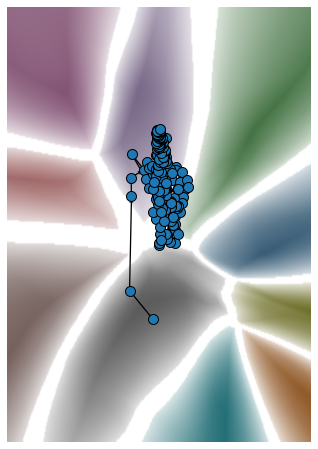

In [22]:
xy_limit = (xs[idx].min()-5, ys[idx].min()-5, xs[idx].max()+5, ys[idx].max()+5)
print(xy_limit)
vis.savefig_trajectory(200, xs[idx][:-1], ys[idx][:-1], xy_limit=xy_limit, path="./vis")

(-821.6472310870452, -1.6893491744995117, 3.0970137119293213, 964.6046420181578)
Computing decision regions ...
Current autocoder model loaded from Epoch 200


100%|██████████| 450/450 [00:00<00:00, 6347.29it/s]


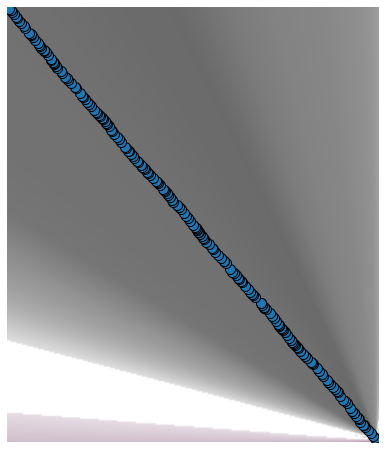

In [26]:
xy_limit = (new_sample[:,0].min()-5, new_sample[:, 1].min()-5, new_sample[:,0].max()+5, new_sample[:, 1].max()+5)
print(xy_limit)
vis.savefig_trajectory(200, new_sample[:,0], new_sample[:, 1], xy_limit=xy_limit, path=".")

In [11]:
tm.score_new_sample(embeddings_2d[1][-tm.period:])

(0.96944, 0.92994, 0.89802)

In [15]:
new_sample = embeddings_2d[1]
new_sample[-1,0] = 0
new_sample[-1,1] = 0


In [ ]:
# random init
print("Random sampling init")
s_rate = list()
pool = np.arange(LEN)
for _ in range(INIT_ROUND):
    s_idxs = np.random.choice(pool,size=BUDGET,replace=False)
    s_rate.append(len(np.intersect1d(s_idxs, noise_idxs))/BUDGET)
print("Success Rate:\t{:.4f}".format(sum(s_rate)/len(s_rate)))


In [ ]:
# dvi init
init_sampling(tm, method=VIS_METHOD, round=INIT_ROUND, budget=BUDGET)

In [ ]:
# random Feedback
print("Random sampling feedback")
random_rate = np.zeros(ROUND)
pool = np.arange(LEN)
for r in range(ROUND):
    s_idxs = np.random.choice(pool,size=BUDGET,replace=False)
    random_rate[r] = len(np.intersect1d(s_idxs, noise_idxs))/BUDGET
    pool = np.setdiff1d(pool, s_idxs)
print("Success Rate:\t{:.4f}".format(sum(random_rate)/len(random_rate)))
ac_random_rate = np.array([random_rate[:i].mean() for i in range(1, len(random_rate)+1)])
print(ac_random_rate)

In [ ]:
# dvi Feedback
feedback_sampling(tm=tm, method=VIS_METHOD, round=ROUND, budget=BUDGET)

In [ ]:
# dvi Feedback with noise
feedback_sampling(tm=tm, method=VIS_METHOD, round=ROUND, budget=BUDGET, noise_rate=TOLERANCE)